In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from spatial_genomics_autoencoders.data.spatial_transcriptomics import (
    OverlaidHETransform, STDataset, MultisampleSTDataset, adata_from_visium)
from spatial_genomics_autoencoders.data.utils import get_means_and_stds

In [5]:
train_ids = ['s0', 's3']
val_ids = ['s3']
fps = [
    '/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s0.h5ad',
    '/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s3.h5ad',
]
sid_to_adata = {fp.split('/')[-1].split('.')[0]:sc.read_h5ad(fp) for fp in fps}

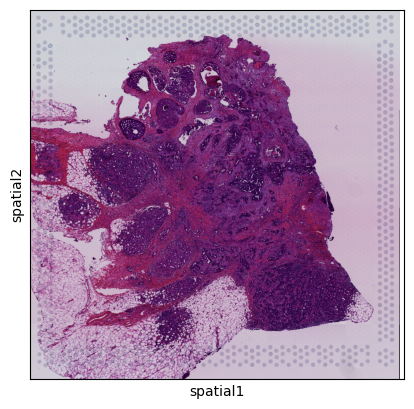

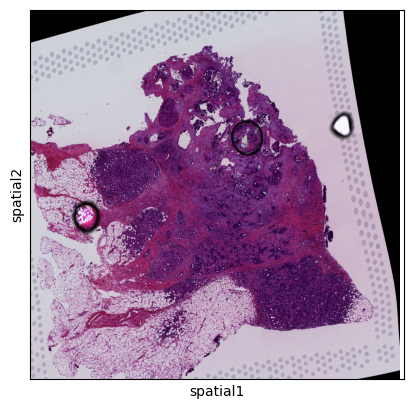

In [6]:
for sid, adata in sid_to_adata.items():
    shape = adata.uns['he_rescaled_warped'].shape
    fig, ax = plt.subplots()
    sc.pl.spatial(adata, ax=ax, crop_coord=(0, shape[0], 0, shape[1]))
    ax.set_title(sid)
    plt.show()

In [7]:
train_adatas = {sid:sid_to_adata[sid] for sid in train_ids}
val_adatas = {sid:sid_to_adata[sid] for sid in val_ids}

train_hes = {sid:a.uns['he_rescaled_warped']
            for sid, a in train_adatas.items()}
val_hes = {sid:a.uns['he_rescaled_warped']
            for sid, a in val_adatas.items()}

In [8]:
means, stds = get_means_and_stds(train_adatas.values())
means, stds

(tensor([0.5939, 0.4522, 0.5963]), tensor([0.2585, 0.3227, 0.2573]))

In [33]:
context_res = 2
size = (128, 128)
exp_size = (16, 16)
he_scale = .2

train_transform = OverlaidHETransform(
    p=.95, size=(int(size[0] * context_res), int(size[1] * context_res)),
    means=means, stds=stds)
sid_to_train_ds = {sid:STDataset(
                        a, train_hes[sid], is_fullres=True,
                        size=size, transform=train_transform, he_scale=he_scale)
                    for sid, a in train_adatas.items()}

keys: dict_keys(['he', 'labeled_img', 'context_he', 'context_labeled_img', 'voxel_idxs', 'masks', 'exp', 'n_voxels'])


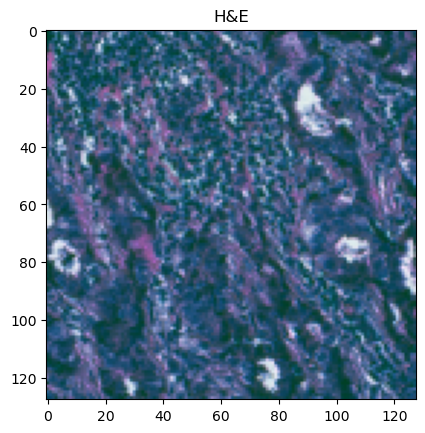

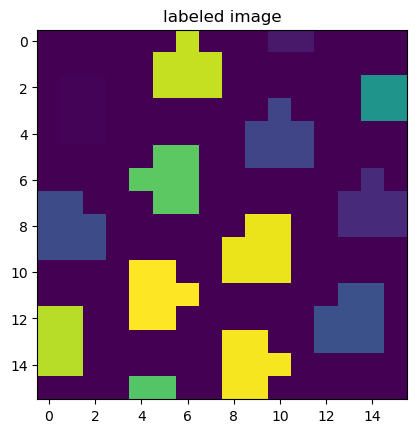

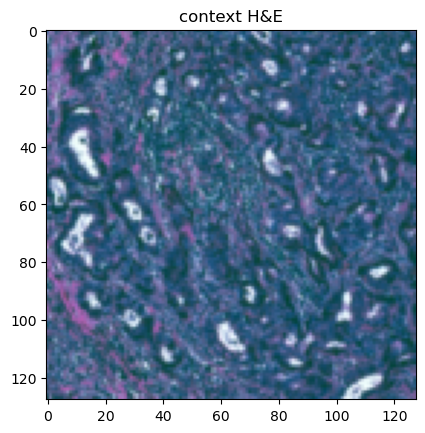

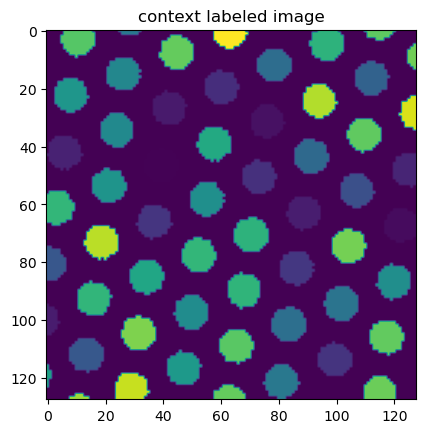

voxel idxs: tensor([  23,  142,  250,  422,  467,  500, 1045, 1481, 1516, 1804, 1850, 1967,
        1993, 2024,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
labeled image voxel idxs: tensor([   0,   23,  142,  250,  422,  467,  500, 1045, 1481, 1516, 1804, 1850,
        1967, 1993, 2024], dtype=torch.int32)
context labeled image voxel idxs:  tensor([   0,   23,   95,  142,  222,  231,  250,  297,  314,  400,  422,  453,
         467,  500,  749,  833,  838,  962, 1045, 1092, 1119, 1177, 1220, 1225,
        1412, 1444, 1481, 1513, 1516, 1585, 1608, 1645, 1748, 1804, 1850, 1967,
        1977, 1993, 2006, 2016, 2024, 2248, 2272, 2300, 2308, 2313, 2325, 2333,
        2369, 2384, 2417, 2467, 2616, 2695, 2735

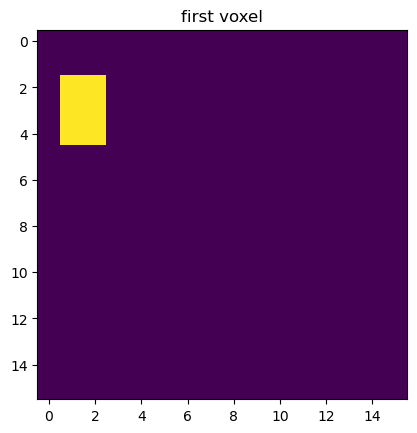

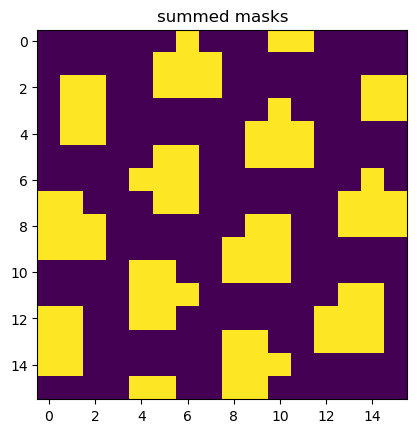

expression counts shape: torch.Size([64, 17943])
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


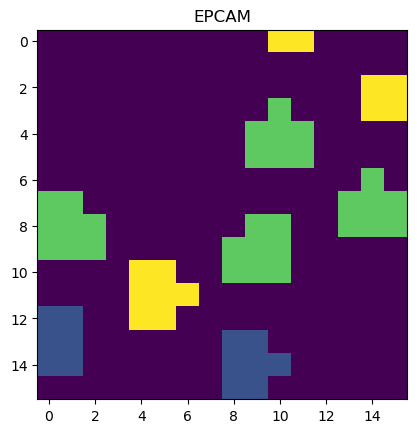

In [34]:
ds = next(iter(sid_to_train_ds.values()))
ds.sanity_check(gene='EPCAM')

In [35]:
val_transform = OverlaidHETransform(
    p=0., size=(int(size[0] * context_res), int(size[1] * context_res)),
    means=means, stds=stds)
sid_to_val_ds = {sid:STDataset(
                        a, val_hes[sid], is_fullres=True,
                        size=size, transform=val_transform, he_scale=he_scale)
                    for sid, a in val_adatas.items()}

In [36]:
train_ds = MultisampleSTDataset(sid_to_train_ds)
val_ds = MultisampleSTDataset(sid_to_val_ds)

In [37]:
train_ds.ds_to_max_voxels

{'s0': 64, 's3': 64}

In [38]:
num_workers = 1
batch_size = 4
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [39]:
b = next(iter(train_dl))
for k, v in b.items():
    print(k, v.shape)

he torch.Size([4, 3, 128, 128])
labeled_img torch.Size([4, 1, 16, 16])
context_he torch.Size([4, 3, 128, 128])
context_labeled_img torch.Size([4, 1, 128, 128])
voxel_idxs torch.Size([4, 64])
masks torch.Size([4, 64, 16, 16])
exp torch.Size([4, 64, 17943])
n_voxels torch.Size([4])
